<h1 style="text-align:center; color:#191970; font-weight:bold;">Value at Risk (VaR) as a Tool for Market Risk Assessment: Lessons from Historical Financial Crises</h1>

Import necessary libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import yfinance as yf
import os

In [19]:
sns.set_style("whitegrid")

plt.rc("figure", figsize=(16, 8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

<h2 style="color:#191970; font-weight:bold;">Methodology: A 3 Phase Framework</h2>

## <span style="color:darkred; font-weight:bold;">Phase 1: Data Preprocessing and Simulation Creation</span>


### Data Collection

In [20]:
tickers = ['^GDAXI', '^GSPC', '^DJI']
start_date = '2007-01-01'
end_date = '2009-01-01'

data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  3 of 3 completed


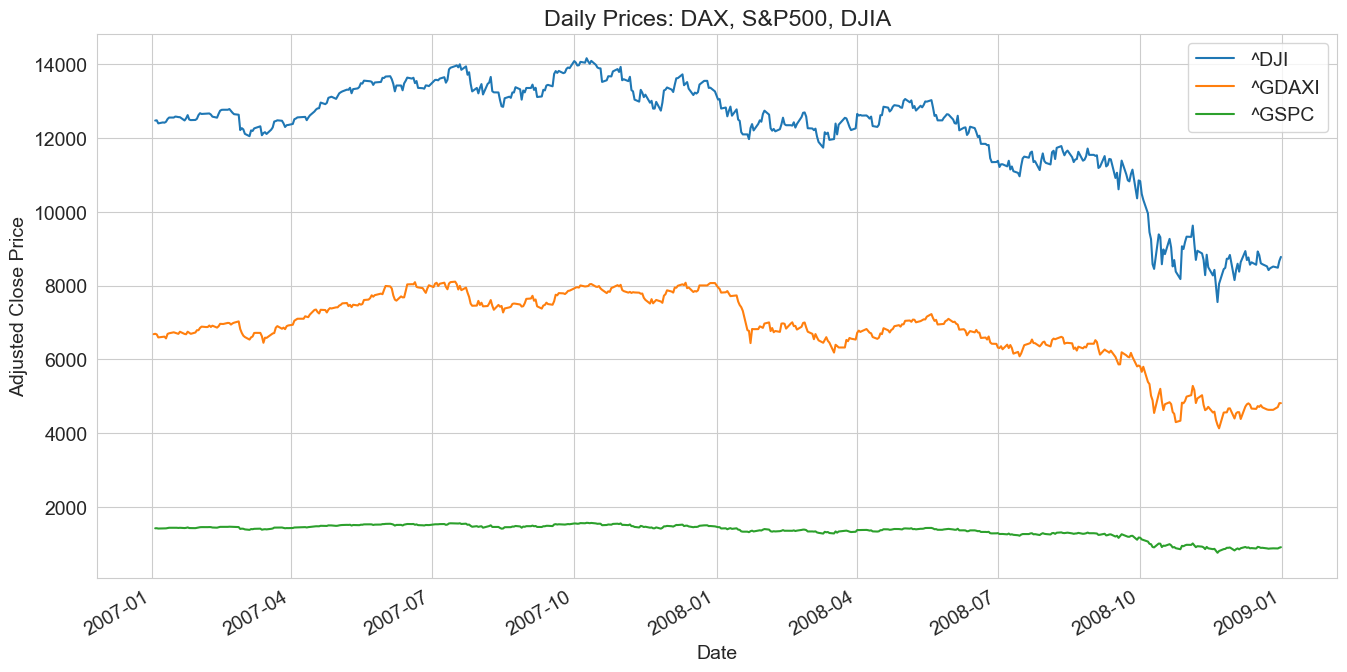

In [21]:
prices = data['Adj Close'].copy()

# Forward fill missing values
prices.ffill(inplace=True)

# Plotting the prices
prices.plot()
plt.title('Daily Prices: DAX, S&P500, DJIA')
plt.ylabel('Adjusted Close Price')
plt.show()

### Log Returns Transformation

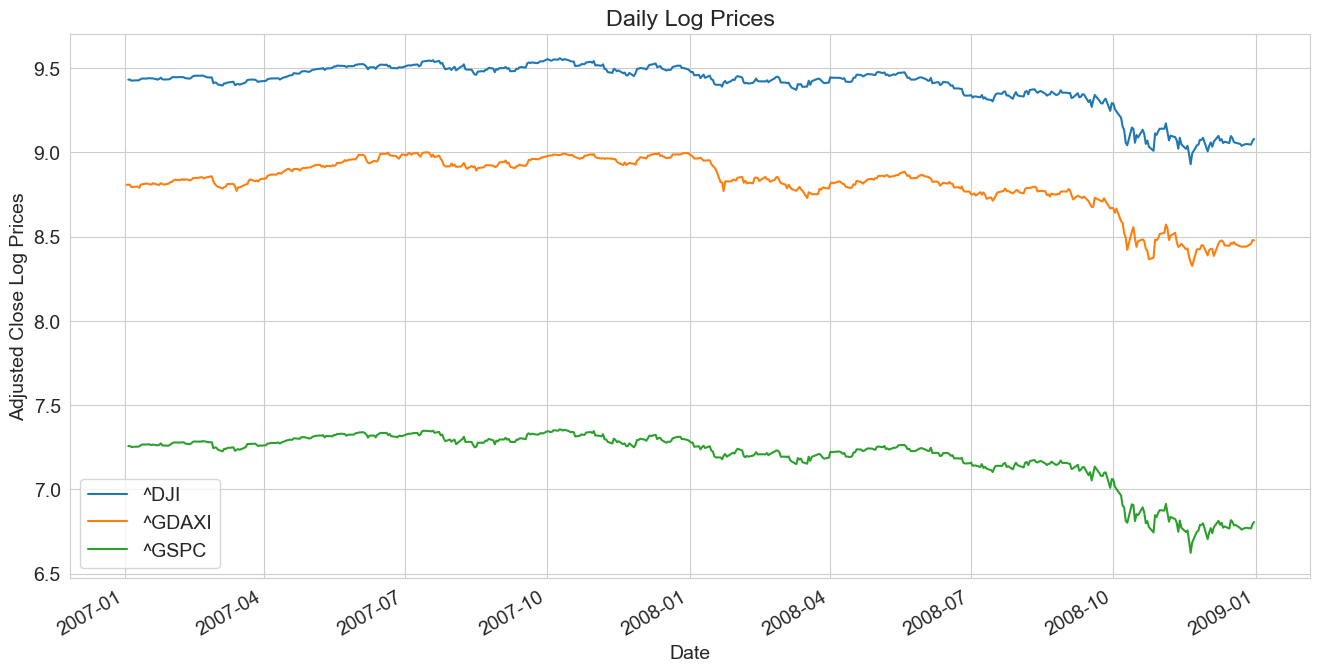

In [22]:
np.log(prices).plot()
plt.ylabel('Adjusted Close Log Prices')
plt.title('Daily Log Prices')
plt.show()

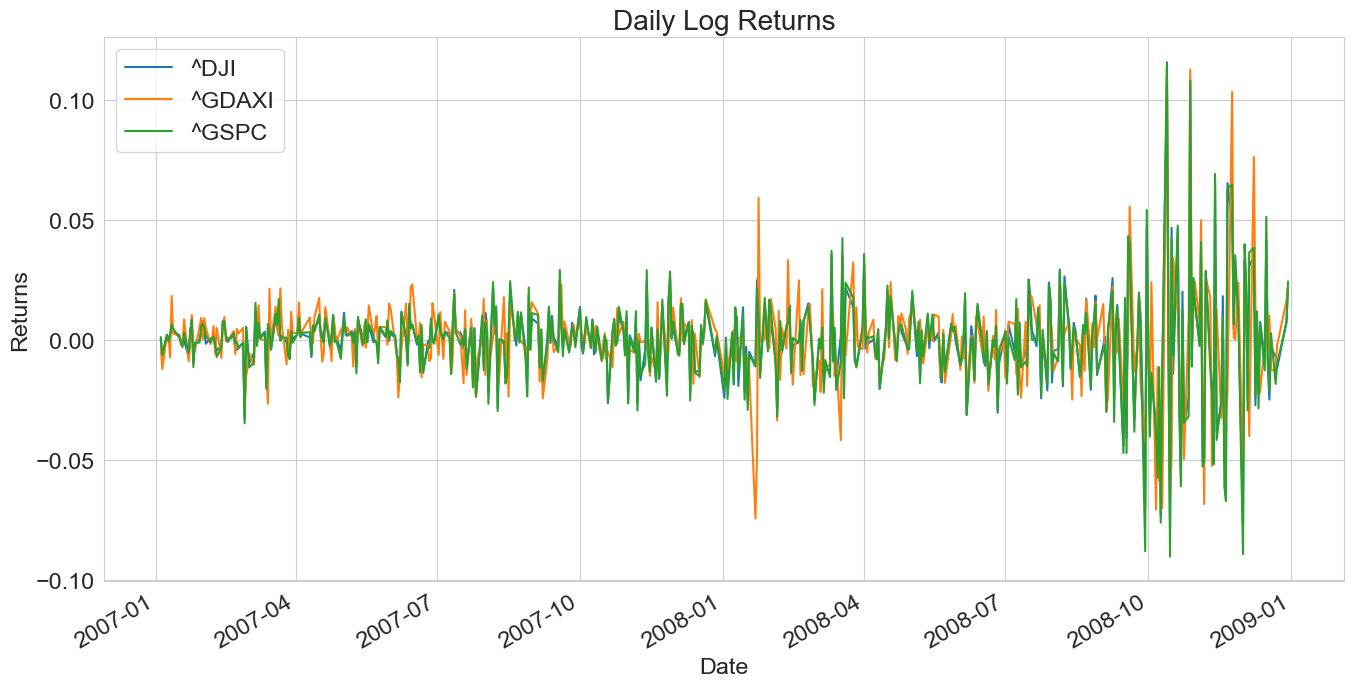

In [37]:
returns = data['Adj Close'].dropna().pct_change()

returns.plot()
plt.title('Daily Log Returns')
plt.ylabel('Returns')
plt.savefig('Daily_returns.png')  
plt.show()

In [24]:
returns_summary = (returns*100).describe()
returns_summary.round(2)[1:]

,^DJI,^GDAXI,^GSPC
mean,-0.06,-0.05,-0.07
std,1.83,1.86,1.98
min,-7.87,-7.45,-9.03
25%,-0.78,-0.79,-0.88
50%,0.04,0.04,0.05
75%,0.66,0.77,0.66
max,11.08,11.40,11.58


In [25]:
# Transfer summary statistics table into latex (dissertation specific)
returns_summary = (returns*100).describe()
latex_table = returns_summary.round(2).to_latex()
print(latex_table)

\begin{tabular}{lrrr}
\toprule
 & ^DJI & ^GDAXI & ^GSPC \\
\midrule
count & 493.000000 & 493.000000 & 493.000000 \\
mean & -0.060000 & -0.050000 & -0.070000 \\
std & 1.830000 & 1.860000 & 1.980000 \\
min & -7.870000 & -7.450000 & -9.030000 \\
25% & -0.780000 & -0.790000 & -0.880000 \\
50% & 0.040000 & 0.040000 & 0.050000 \\
75% & 0.660000 & 0.770000 & 0.660000 \\
max & 11.080000 & 11.400000 & 11.580000 \\
\bottomrule
\end{tabular}



In [26]:
data

Adj Close                                   Close               \
                    ^DJI       ^GDAXI        ^GSPC          ^DJI       ^GDAXI   
Date                                                                            
2007-01-02           NaN  6681.129883          NaN           NaN  6681.129883   
2007-01-03  12474.519531  6691.319824  1416.599976  12474.519531  6691.319824   
2007-01-04  12480.690430  6674.399902  1418.339966  12480.690430  6674.399902   
2007-01-05  12398.009766  6593.089844  1409.709961  12398.009766  6593.089844   
2007-01-08  12423.490234  6607.589844  1412.839966  12423.490234  6607.589844   
...                  ...          ...          ...           ...          ...   
2008-12-24   8468.480469          NaN   868.150024   8468.480469          NaN   
2008-12-26   8515.549805          NaN   872.799988   8515.549805          NaN   
2008-12-29   8483.929688  4704.859863   869.419983   8483.929688  4704.859863   
2008-12-30   8668.389648  4810.200195   890.640015   8668.389648  4810.200195   
2008-12-31   8776.389648          NaN   903.250000   8776.389648          NaN   

                                 High                                     Low  \
                  ^GSPC          ^DJI       ^GDAXI        ^GSPC          ^DJI   
Date                                                                            
2007-01-02          NaN           NaN  6682.810059          NaN           NaN   
2007-01-03  1416.599976  12580.349609  6704.040039  1429.420044  12404.820312   
2007-01-04  1418.339966  12510.410156  6684.109863  1421.839966  12403.860352   
2007-01-05  1409.709961  12480.129883  6665.509766  1418.339966  12365.410156   
2007-01-08  1412.839966  12445.919922  6628.359863  1414.979980  12337.370117   
...                 ...           ...          ...          ...           ...   
2008-12-24   868.150024   8498.500000          NaN   869.789978   8416.860352   
2008-12-26   872.799988   8533.070312          NaN   873.739990   8461.780273   
2008-12-29   869.419983   8530.679688  4732.850098   873.700012   8364.059570   
2008-12-30   890.640015   8675.240234  4810.410156   891.119995   8487.509766   
2008-12-31   903.250000   8842.660156          NaN   910.320007   8664.889648   

                                              Open                            \
                 ^GDAXI        ^GSPC          ^DJI       ^GDAXI        ^GSPC   
Date                                                                           
2007-01-02  6614.729980          NaN           NaN  6614.729980          NaN   
2007-01-03  6667.580078  1407.859985  12459.540039  6681.229980  1418.030029   
2007-01-04  6634.740234  1408.430054  12473.160156  6662.240234  1416.599976   
2007-01-05  6588.029785  1405.750000  12480.049805  6661.899902  1418.339966   
2007-01-08  6579.899902  1403.969971  12392.009766  6603.549805  1409.260010   
...                 ...          ...           ...          ...          ...   
2008-12-24          NaN   861.440002   8416.860352          NaN   863.869995   
2008-12-26          NaN   866.520020   8468.709961          NaN   869.510010   
2008-12-29  4655.910156   857.070007   8515.870117  4660.169922   872.369995   
2008-12-30  4754.220215   870.580017   8487.509766  4754.220215   870.580017   
2008-12-31          NaN   889.669983   8666.480469          NaN   890.590027   

                 Volume                             
                   ^DJI       ^GDAXI         ^GSPC  
Date                                                
2007-01-02          NaN   70947800.0           NaN  
2007-01-03  327200000.0  105913800.0  3.429160e+09  
2007-01-04  259060000.0  143461600.0  3.004460e+09  
2007-01-05  235220000.0  142562500.0  2.919400e+09  
2007-01-08  223500000.0  116670200.0  2.763340e+09  
...                 ...          ...           ...  
2008-12-24   66930000.0          NaN  1.546550e+09  
2008-12-26   86760000.0          NaN  1.880050e+09  
2008-12-29  153730000.0  100697000.0  3.3

### EHS VaR (Student's t-distribution)

In [27]:
confidence_level = 0.95
time_horizon = 1
common_degrees_of_freedom = 5  #The lower the DF (v), the fatter the tails 

var_results_list = []

#'returns' is the DataFrame containing my log returns
for index_name in returns.columns:
    var = stats.t.ppf(1 - confidence_level, common_degrees_of_freedom, 
                      loc=returns[index_name].mean(), 
                      scale=returns[index_name].std())
    var_results_list.append({'tickers': index_name, 'VaR': var})

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR
0    ^DJI -0.037441
1  ^GDAXI -0.037917
2   ^GSPC -0.040712


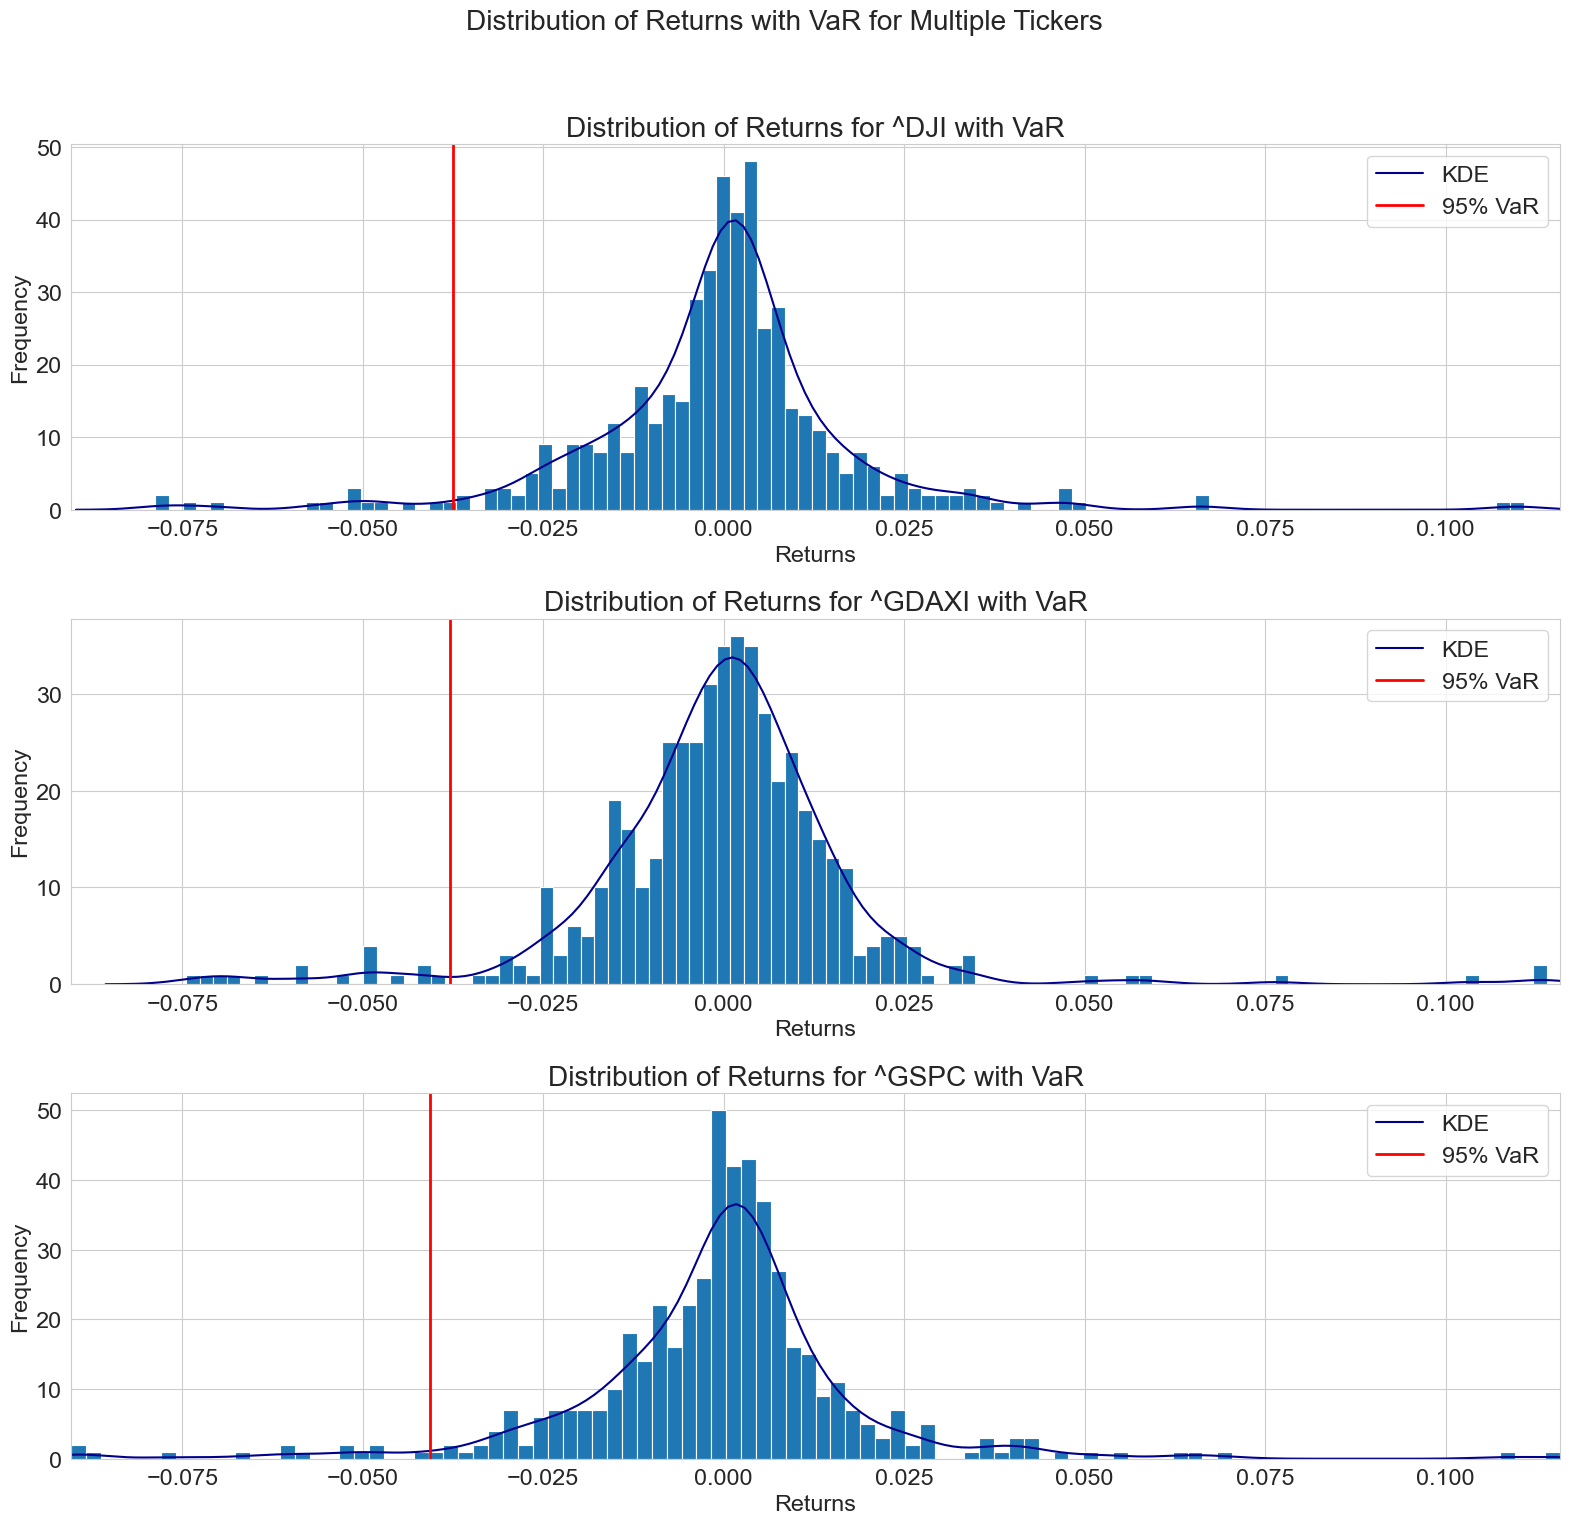

In [28]:
plt.rcParams.update({'font.size': 16.8})

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 15))

# Get the overall minimum and maximum values of log returns across all tickers
min_return = returns.min().min()
max_return = returns.max().max()

# Plot distribution with KDE for each ticker in a subplot
for i, index_name in enumerate(returns.columns):
    sns.histplot(returns[index_name], color='#1f77b4', bins=100, ax=axes[i], alpha=1, kde_kws={'bw_method': 25})  # Specify bandwidth for histplot

    # Create a separate KDE plot 
    sns.kdeplot(returns[index_name], color='darkblue', ax=axes[i], label='KDE', bw_method=0.2)  # Specify bandwidth for kdeplot
    
    axes[i].axvline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0], color='red', linestyle='solid', linewidth=2, label='95% VaR')
    axes[i].set_title(f'Distribution of Returns for {index_name} with VaR')
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(min_return, max_return)  
    axes[i].legend()

fig.suptitle('Distribution of Returns with VaR for Multiple Tickers', y=1.02)

plt.tight_layout()

plt.savefig('Distribution_of_Returns_with_VaR.png')

plt.show()

In [35]:
print(returns.isnull().sum())

^DJI      1
^GDAXI    1
^GSPC     1
dtype: int64


#### Distribution Analysis (Skewness and Kurtosis)

In [36]:
# Calculate skewness and kurtosis for each distribution of returns
skewness_list = []
kurtosis_list = []

for index_name in returns.columns:
    skewness = np.nan_to_num(np.mean((returns[index_name] - np.mean(returns[index_name])) ** 3) / np.std(returns[index_name]) ** 3)
    kurtosis = np.nan_to_num(np.mean((returns[index_name] - np.mean(returns[index_name])) ** 4) / np.std(returns[index_name]) ** 4 - 3)
    print(f"Stock Index: {index_name}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print("------------------------")

Stock Index: ^DJI
Skewness: 0.35796110173421847
Kurtosis: 7.6111969267451425
------------------------
Stock Index: ^GDAXI
Skewness: 0.694853014835956
Kurtosis: 9.494462290010675
------------------------
Stock Index: ^GSPC
Skewness: 0.09071380277051277
Kurtosis: 7.238392905897902
------------------------


## <span style="color:darkred; font-weight:bold;">Phase 2: Model Sensitivity and Backtesting</span>

### Sensitivity Testing

#### Sensitivity Analysis: Confidence Level

In [30]:
def calculate_var(returns, confidence_level=0.95, time_horizon=1, degrees_of_freedom=5):
    var_results_list = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - confidence_level, degrees_of_freedom,
                          loc=returns[index_name].mean(),
                          scale=returns[index_name].std())
        var_results_list.append({'tickers': index_name, 'VaR': var})

    var_results = pd.DataFrame(var_results_list)

    # Check for NaN values
    if var_results.isnull().values.any():
        print("Warning: NaN values detected in the result.")

    return var_results

# Original calculation of Var (Default parameters)
confidence_level_original = 0.95
time_horizon_original = 1
common_degrees_of_freedom = 5

var_results_original = calculate_var(returns, confidence_level_original, time_horizon_original, common_degrees_of_freedom)
print("Original results:")
print(var_results_original)

# Sensitivity analysis with different confidence levels (90% and 99%)
confidence_levels = [0.90, 0.99]

for level in confidence_levels:
    var_results_sensitivity = calculate_var(returns, confidence_level=level, time_horizon=time_horizon_original, degrees_of_freedom=common_degrees_of_freedom)
    print(f"Results for confidence level {level}:")
    print(var_results_sensitivity)

Original results:
  tickers       VaR
0    ^DJI -0.037441
1  ^GDAXI -0.037917
2   ^GSPC -0.040712
Results for confidence level 0.9:
  tickers       VaR
0    ^DJI -0.027576
1  ^GDAXI -0.027905
2   ^GSPC -0.030018
Results for confidence level 0.99:
  tickers       VaR
0    ^DJI -0.062140
1  ^GDAXI -0.062984
2   ^GSPC -0.067486


#### Sensitivity Analysis: Time Horizon

In [31]:
common_confidence_level = 0.95
common_degrees_of_freedom = 5 

time_horizons = [1, 5, 21]  #Different time horizons to analyze (Default at 1 day, testing 5-day and 21-day time horizons)
# Create Dataframe
var_results_list = []

for time_horizon in time_horizons:
    temp_var_results = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - common_confidence_level, common_degrees_of_freedom, 
                          loc=returns[index_name].mean(), 
                          scale=returns[index_name].std() * (time_horizon ** 0.5))
        temp_var_results.append({'tickers': index_name, 'VaR': var, 'Time Horizon': time_horizon})

    var_results_list.extend(temp_var_results)

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR  Time Horizon
0    ^DJI -0.037441             1
1  ^GDAXI -0.037917             1
2   ^GSPC -0.040712             1
3    ^DJI -0.083015             5
4  ^GDAXI -0.084169             5
5   ^GSPC -0.090114             5
6    ^DJI -0.169530            21
7  ^GDAXI -0.171973            21
8   ^GSPC -0.183898            21


### Time Series Plot

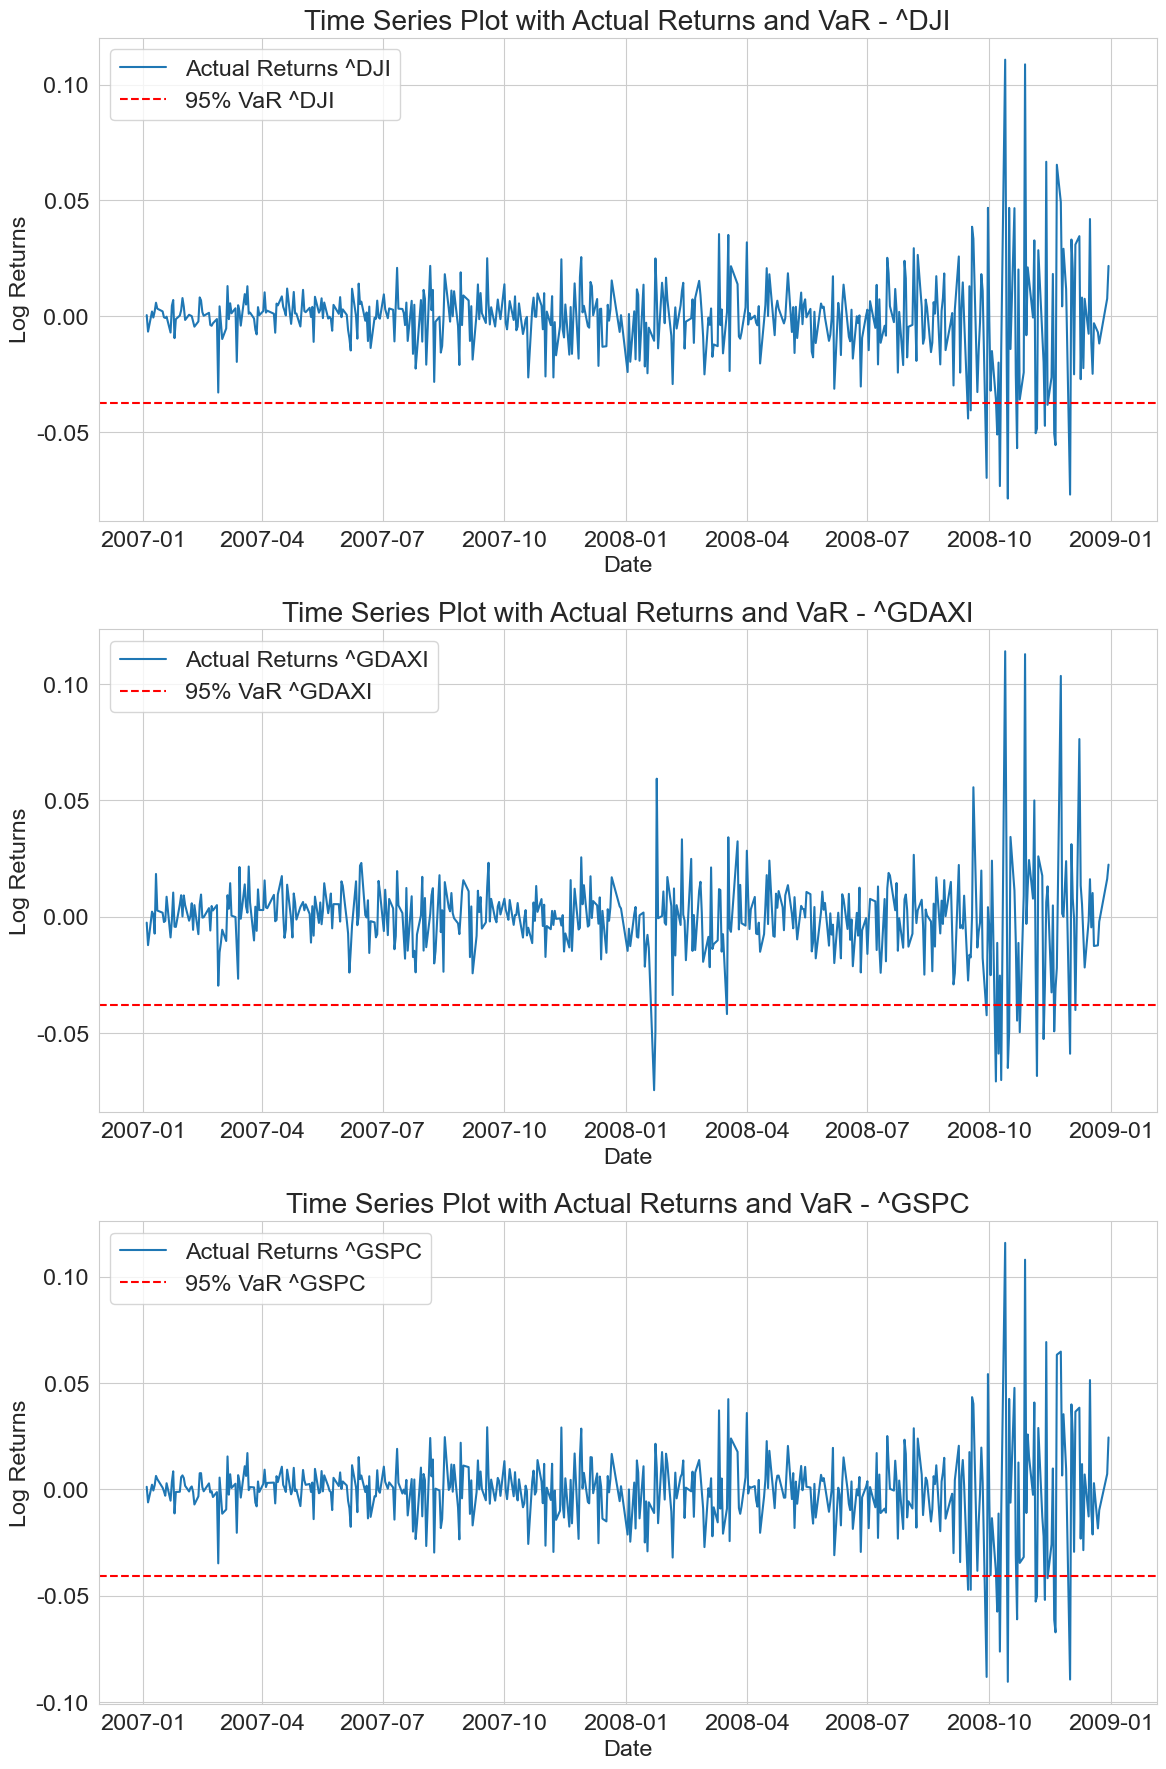

In [32]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Create a single figuren of all 3 stocks
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting actual log returns and VaR for each index
for i, index_name in enumerate(returns.columns):
    
    # Actual log returns
    axes[i].plot(returns.index, returns[index_name], label=f'Actual Returns {index_name}')
    
    # VaR line
    axes[i].axhline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0],
                    linestyle='dashed', color='red', label=f'95% VaR {index_name}')

    axes[i].set_title(f'Time Series Plot with Actual Returns and VaR - {index_name}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Log Returns')

    # Setting y-axis ticks to 2 decimal places
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
    

    axes[i].legend()

plt.tight_layout()

plt.savefig('Time_Series_Plot_All.png')

plt.show()

### Backtesting

#### Exceedance Test

In [33]:
# Create an empty list to store exceedance count results
exceedance_results = []

# Exceedance count test
for index_name in returns.columns:
    va_r = var_results[var_results['tickers'] == index_name]['VaR'].iloc[0]
    exceedances = returns[returns[index_name] < va_r]
    num_exceedances = len(exceedances)

    # Append results to the list
    exceedance_results.append({'Index': index_name, 'Exceedance Count': num_exceedances})

# Create a DataFrame from the list
exceedance_df = pd.DataFrame(exceedance_results)

print(exceedance_df)

    Index  Exceedance Count
0    ^DJI                14
1  ^GDAXI                16
2   ^GSPC                14


#### Kupiec Test

The Kupiec Test was performed in Excel outside of this environment. This was necessitated by issues related to the Python 3.12 version, which lacked the 'vartests' packages required for conducting the test.

In [34]:
output_folder = 'returns_excel_files/'
os.makedirs(output_folder, exist_ok=True)

# Export returns data for each stock index to a separate Excel file
for index_name in returns.columns:
    returns_data = pd.DataFrame({'Date': returns.index, 'Returns': returns[index_name]})
    excel_filename = f'{output_folder}{index_name}_returns.xlsx'
    returns_data.to_excel(excel_filename, index=False)
    print(f"Returns data for {index_name} exported to {excel_filename}")

Returns data for ^DJI exported to returns_excel_files/^DJI_returns.xlsx
Returns data for ^GDAXI exported to returns_excel_files/^GDAXI_returns.xlsx
Returns data for ^GSPC exported to returns_excel_files/^GSPC_returns.xlsx
